In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import plotly.io as pio

pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [2]:
df = sns.load_dataset('iris')

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Marginal Hexplot
- display correlation of two features
- hexplot shoes density of corrolation

/Users/heymanjake/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2036: UserWarning:

The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.

/Users/heymanjake/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2036: UserWarning:

The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.



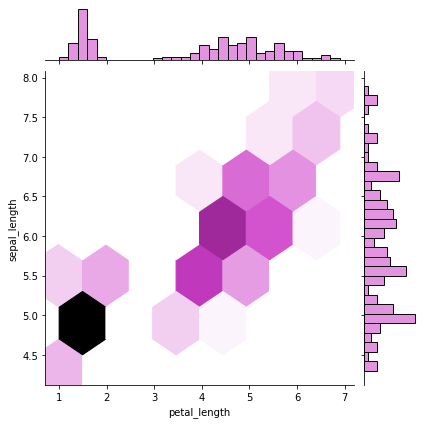

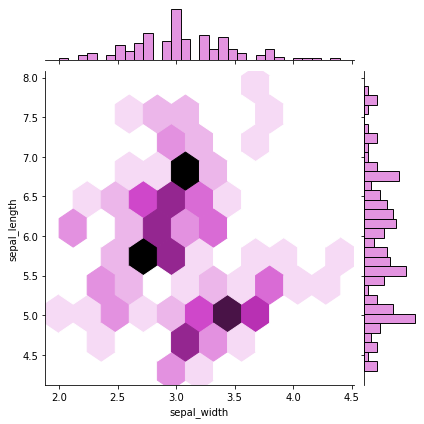

In [4]:
sns.jointplot(x=df["petal_length"], y=df["sepal_length"], color= 'orchid',
              kind='hex', marginal_kws=dict(bins=30, rug=True))
sns.jointplot(x=df["sepal_width"], y=df["sepal_length"], color= 'orchid',
              kind='hex', marginal_kws=dict(bins=30, rug=True))

# Jointgrid
- a more flexible joint plot that lets you select the bivariate plots

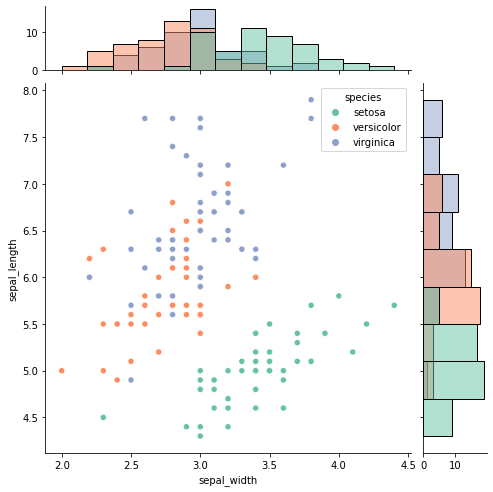

In [5]:
g = sns.JointGrid(data=df, x='sepal_width', y='sepal_length',
                  hue='species',palette='Set2',
                  height=7,marginal_ticks=True)

g.plot(sns.scatterplot, sns.histplot)

# Distplot
- kernal density displot with target variables
- added a rugmap just for fun to see the individual occurances of instances in the data

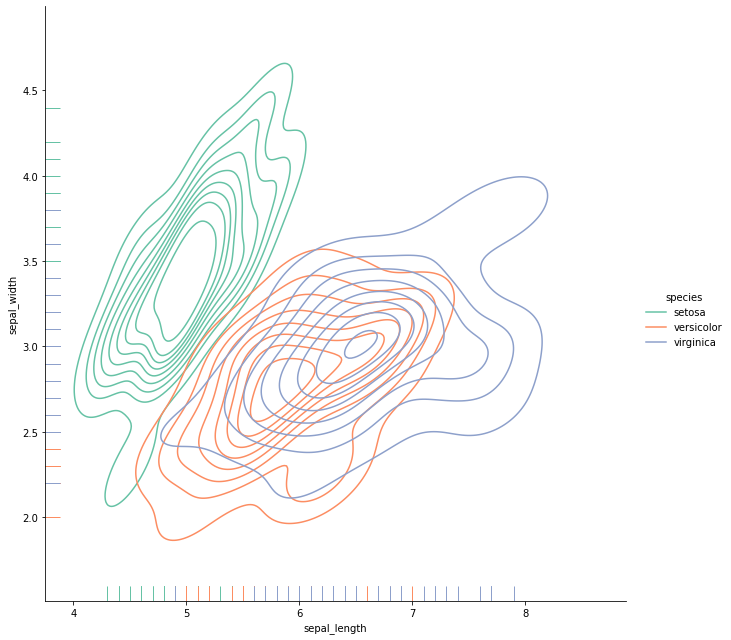

In [6]:
sns.displot(data=df,
          x='sepal_length',hue='species',
          y='sepal_width',kind='kde',
            height=9,
           palette='Set2',rug=True)


# Clustermap
- hierarchical clustered heatmap with dendrogram
- I think this is more convoluted than a regular corrolative heatmap

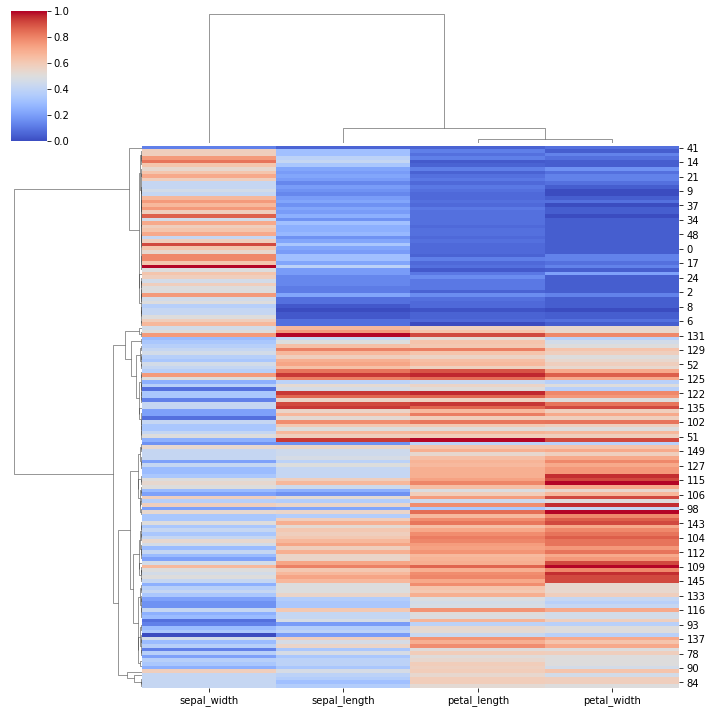

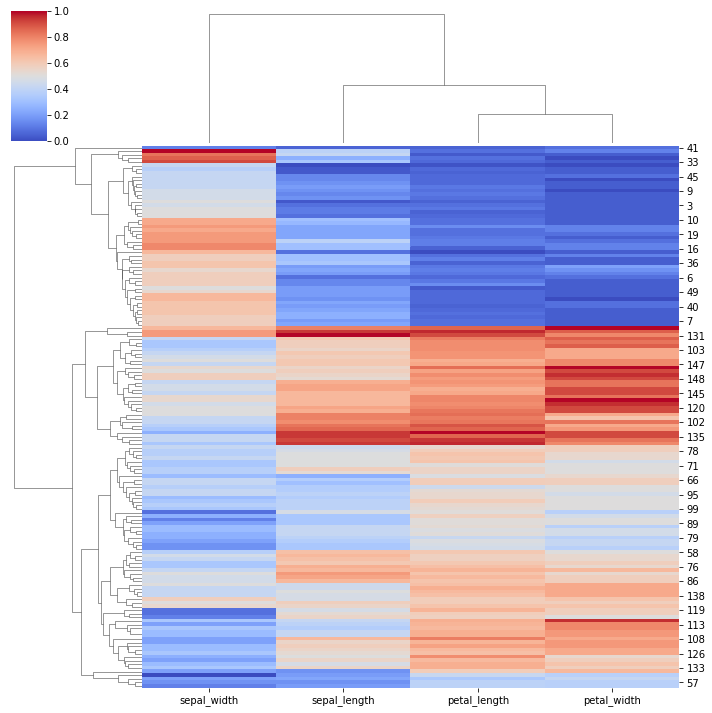

In [7]:
df1 = df.drop('species',axis=1)
sns.clustermap(df1, metric="correlation", standard_scale=1, cmap='coolwarm')

sns.clustermap(df1, metric="euclidean", standard_scale=1, cmap='coolwarm')

# Pairplot
- plot pairwise relationships
- markers changes the shape of the scatter dots
- fun way to see distribution of your target for all features

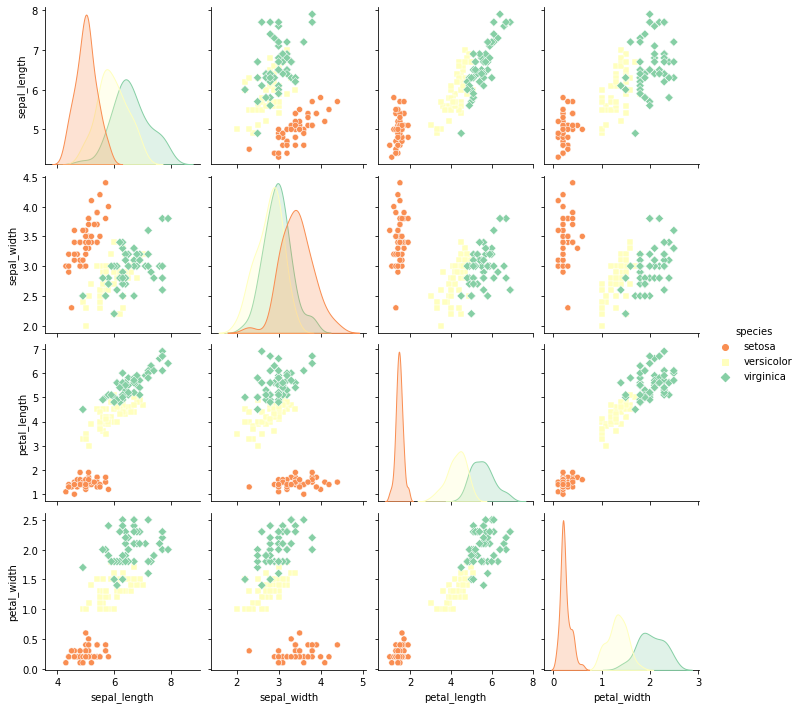

In [8]:
sns.pairplot(df, kind="scatter", hue="species",markers=["o", "s", "D"] , palette="Spectral")



# 2d PCA
- scatterplot of first two principal companants
- target variable is color labled


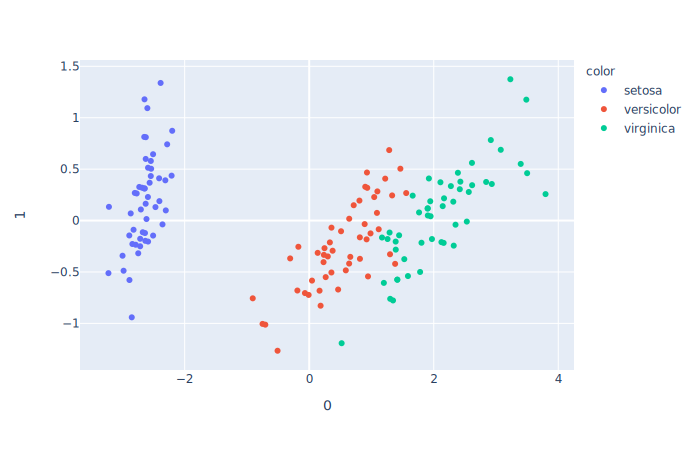

In [9]:
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=df['species'])
fig.show(renderer="svg")

# 3D PCA scatterplot
- three dimensianal graph of principal components (cool way to show the dimensions of your data)
- color the target class and see the distribution of principal componants
- shows dimensianility of data

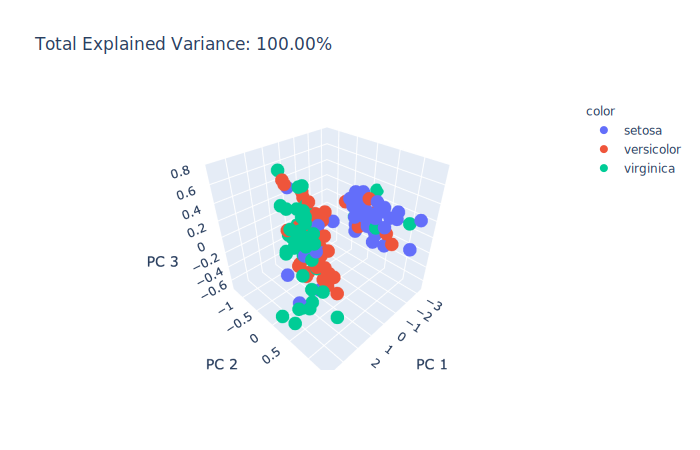

In [14]:
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

pca = PCA(n_components=4)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['species'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show(renderer="svg")

# LinaerRegression risidual plot


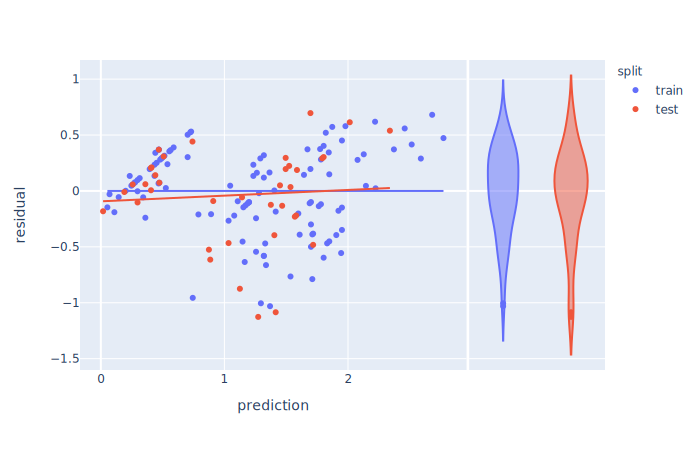

In [15]:
df = px.data.iris()

# Split data into training and test splits
train_idx, test_idx = train_test_split(df.index, test_size=.25, random_state=0)
df['split'] = 'train'
df.loc[test_idx, 'split'] = 'test'

X = df[['sepal_width', 'sepal_length']]
X_train = df.loc[train_idx, ['sepal_width', 'sepal_length']]
y_train = df.loc[train_idx, 'petal_width']

# Condition the model on sepal width and length, predict the petal width
model = LinearRegression()
model.fit(X_train, y_train)
df['prediction'] = model.predict(X)
df['residual'] = df['prediction'] - df['petal_width']

fig = px.scatter(
    df, x='prediction', y='residual',
    marginal_y='violin',
    color='split', trendline='ols'
)
fig.show(renderer="svg")

# gridsearch visualizations

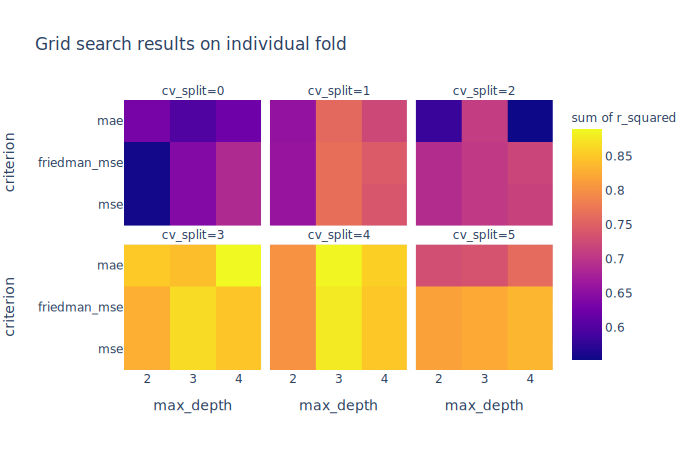

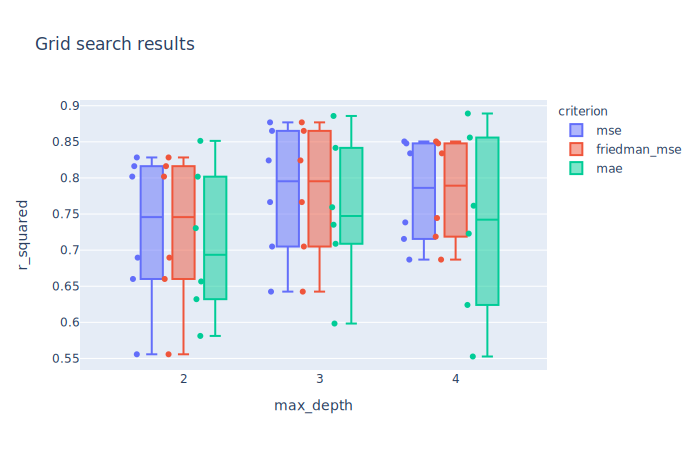

In [17]:
N_FOLD = 6

# Load and shuffle dataframe
df = px.data.iris()
df = df.sample(frac=1, random_state=0)

X = df[['sepal_width', 'sepal_length']]
y = df['petal_width']

# Define and fit the grid
model = DecisionTreeRegressor()
param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': range(2, 5)
}
grid = GridSearchCV(model, param_grid, cv=N_FOLD)
grid.fit(X, y)
grid_df = pd.DataFrame(grid.cv_results_)

# Convert the wide format of the grid into the long format
# accepted by plotly.express
melted = (
    grid_df
    .rename(columns=lambda col: col.replace('param_', ''))
    .melt(
        value_vars=[f'split{i}_test_score' for i in range(N_FOLD)],
        id_vars=['mean_test_score', 'mean_fit_time', 'criterion', 'max_depth'],
        var_name="cv_split",
        value_name="r_squared"
    )
)

# Format the variable names for simplicity
melted['cv_split'] = (
    melted['cv_split']
    .str.replace('_test_score', '')
    .str.replace('split', '')
)

# Single function call to plot each figure
fig_hmap = px.density_heatmap(
    melted, x="max_depth", y='criterion',
    histfunc="sum", z="r_squared",
    title='Grid search results on individual fold',
    hover_data=['mean_fit_time'],
    facet_col="cv_split", facet_col_wrap=3,
    labels={'mean_test_score': "mean_r_squared"}
)

fig_box = px.box(
    melted, x='max_depth', y='r_squared',
    title='Grid search results ',
    hover_data=['mean_fit_time'],
    points='all',
    color="criterion",
    hover_name='cv_split',
    labels={'mean_test_score': "mean_r_squared"}
)

# Display
fig_hmap.show(renderer="svg")
fig_box.show(renderer="svg")

# Roc curve

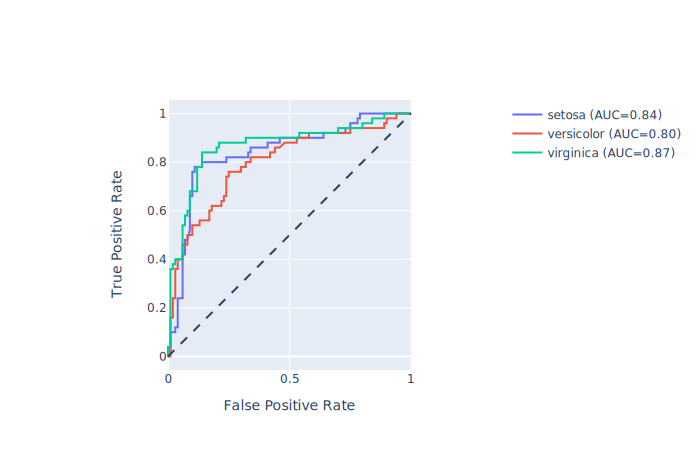

In [19]:
np.random.seed(0)

# Artificially add noise to make task harder
df = px.data.iris()
samples = df.species.sample(n=50, random_state=0)
np.random.shuffle(samples.values)
df.loc[samples.index, 'species'] = samples.values

# Define the inputs and outputs
X = df.drop(columns=['species', 'species_id'])
y = df['species']

# Fit the model
model = LogisticRegression(max_iter=200)
model.fit(X, y)
y_scores = model.predict_proba(X)

# One hot encode the labels in order to plot them
y_onehot = pd.get_dummies(y, columns=model.classes_)

# Create an empty figure, and iteratively add new lines
# every time we compute a new class
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"{y_onehot.columns[i]} (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500
)
fig.show(renderer="svg")